In [2]:
import torch
from torch.cuda import is_available
from torch.optim import Adam
from torch.nn import MSELoss, BCELoss
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
from utils import angle_ims, simple_mean, imshow
from conv3d import Conv3D, PEI

### The outputs after each layer: 
`dim = (batch_size, channels, frames, height, width)`
* Conv3d layer 1: `(1, 16, 1, 160, 120)`

* Conv3d layer 2: `(1, 32, 1, 160, 120)`

* Conv3d layer 3: `(1, 16, 1, 160, 120)`

* Conv3d layer 4: `(1, 1, 1, 160, 120)`


In [7]:
model = Conv3D()
device = 'cuda:0'
print(device)
model.to(device)

cuda:0


Conv3D(
  (conv1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv3d(16, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()

In [5]:
dataset = PEI(15, angle=0, keypose=4)

In [15]:
train_dl = DataLoader(dataset,batch_size=1,shuffle=True)

In [8]:
#Loss
criterion = MSELoss()
#Optimizer
optimizer = Adam(model.parameters(), lr=0.009)

## Training

In [9]:
#Epochs
n_epochs = 7

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for images,y in train_dl:
        images,y = images.to(device), y.to(device)
        optimizer.zero_grad()

        out = model(images)
        temp_out = torch.reshape(out, (out.shape[0],out.shape[3],out.shape[4]))
        loss = criterion(temp_out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
          
    train_loss = train_loss/len(train_dl)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.012244
Epoch: 2 	Training Loss: 0.003888
Epoch: 3 	Training Loss: 0.003691
Epoch: 4 	Training Loss: 0.003541
Epoch: 5 	Training Loss: 0.003217
Epoch: 6 	Training Loss: 0.002624
Epoch: 7 	Training Loss: 0.002131


## Check
`240 images (80 samples from 15 experiments, 3 frames each)`

In [12]:
def ims(model_out,actual):
    # img = img / 2 + 0.5  
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,4))
    axes[0].imshow(model_out,cmap='gray',vmin=0,vmax=1)
    axes[0].set_title('Model')
    axes[1].imshow(actual,cmap='gray',vmin=0,vmax=1)
    axes[1].set_title('Average')
    plt.show()


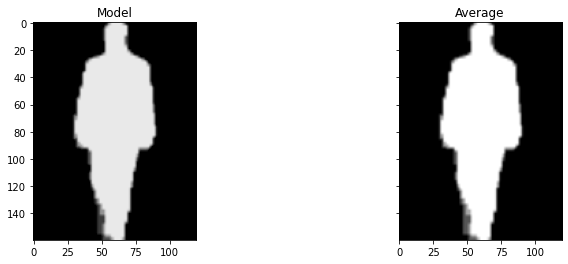

In [17]:
dataiter = iter(train_dl)
images,y = dataiter.next()
# images = images.to('cpu',dtype=torch.float)
# print(type(images),images.shape)

#Sample outputs
output = model(images.to(device=device))
images = images.cpu().numpy().reshape(3,160,120)
output = output.view(160, 120)
output = output.cpu().detach().numpy()

ims(output,y.view(160,120))